# Digit recognition - multiclass classification


## 1.1 Reading collected and MNIST datasets
  
  


In [3]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
from keras.models import Sequential
from skimage.filters import threshold_otsu
from keras.optimizers import RMSprop, SGD, Adam
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization, Reshape
from keras.layers.experimental.preprocessing import RandomTranslation, RandomRotation, RandomWidth, RandomHeight, RandomZoom, Resizing

seed = 173
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
df = pd.read_csv("data/drawings.csv")
mnist = pd.read_csv("data/train.csv")
df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5512,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5513,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5515,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [5]:
def binarize_mnist(image_collection):
    """
    Inverts a collection of images and makes it binary
    """

    imges = [] 

    for img in image_collection:
        # Retrieve an Otsu threshold for the image
        thresh = threshold_otsu(img)
        # Which pixels are beyond the threshold
        binary = img > thresh
        # Flatten
        imges.append(binary.reshape(28*28))

    return imges

# Pass the mnist dataframe into the binarizer and craft a dataframe
mnistBin = pd.DataFrame(binarize_mnist(np.array(mnist.iloc[:,1:]).reshape(len(mnist), 28, 28)))

In [6]:
# attach the appropriate label to each observation
mnistBin["label"] = mnist.label
# convert columns from bool to int
mnistBin = mnistBin + 0
mnistBin

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
41997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
41998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


In [7]:
# join the mnist and custom datasets, shuffle
jointDf = pd.DataFrame(np.concatenate([np.array(df), np.array(mnistBin)]))\
    .sample(frac=1, random_state=seed)\
        .reset_index(drop=True)\
            .rename({784: "label"}, axis=1)

In [8]:
jointDf

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47512,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47513,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
47514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
47515,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Class balance

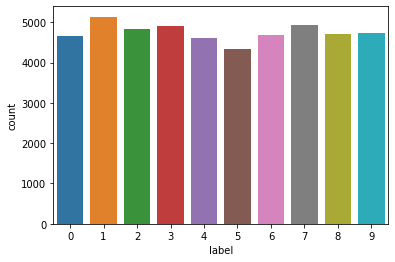

In [9]:
sns.countplot(x = jointDf.label);

#### Training and hold-out sets

In [10]:
y = to_categorical(jointDf.label)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(jointDf.iloc[:,:-1], y, train_size=0.9, random_state=seed) # no need to stratify for large balanced datasets
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((42765, 784), (4752, 784), (42765, 10), (4752, 10))

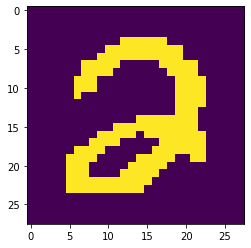

In [12]:
plt.imshow(np.array(x_test.sample(1, random_state=seed)).reshape(28, 28));

In [17]:
def get_model(seed):
        model = Sequential([
                # Preprocessing
                Reshape((28, 28, 1), input_shape=(1, 28*28)),
                RandomRotation(0.12, seed=seed, fill_mode="constant", fill_value=0),
                RandomHeight(0.13, seed=seed, interpolation="bicubic"),
                RandomWidth(0.13, seed=seed, interpolation="bicubic"),
                RandomTranslation(0.16, 0.14, seed=seed, fill_mode="constant", fill_value=0),
                Resizing(28, 28, interpolation="bicubic"),


                # Subsampling-Convolution triplet 1
                Conv2D(32, kernel_size=3, padding="same", activation="relu"),
                BatchNormalization(axis=1),
                Conv2D(32, kernel_size=3, activation="relu"),
                BatchNormalization(axis=1),
                Conv2D(32, kernel_size=5, padding="same", activation="relu", strides=2),
                BatchNormalization(axis=1),
                Dropout(0.3, seed=seed),


                # Subsampling-Convolution triplet 2
                Conv2D(64, kernel_size=3, activation="relu"),
                BatchNormalization(axis=1),
                Conv2D(64, kernel_size=3, activation="relu"),
                BatchNormalization(axis=1),
                Conv2D(64, kernel_size=5, padding="same", activation="relu", strides=2),
                BatchNormalization(axis=1),
                Dropout(0.3, seed=seed),

                # Decision-making
                Flatten(),
                Dense(256, activation="relu"),
                Dropout(0.4, seed=seed),
                Dense(28, activation="sigmoid"),
                BatchNormalization(axis=1),
                Dense(10, activation="softmax")])
        
        opt = RMSprop(learning_rate = 0.001, decay = 0)
        model.compile(opt, "categorical_crossentropy", metrics=["accuracy"])

        return model

lr_cut = ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=2, verbose=1, min_lr=0.000000001, mode="max", cooldown=3)
quicksave = ModelCheckpoint(monitor="val_accuracy", filepath="data/checkpoint.hdf5", verbose=1, save_best_only=True)

model = get_model(seed)
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 28, 28, 1)         0         
_________________________________________________________________
random_height_2 (RandomHeigh (None, None, 28, 1)       0         
_________________________________________________________________
random_width_2 (RandomWidth) (None, None, None, 1)     0         
_________________________________________________________________
random_translation_2 (Random (None, None, None, 1)     0         
_________________________________________________________________
resizing_2 (Resizing)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 32)       

In [18]:
model.load_weights("data/checkpointBest.hdf5")

In [22]:
model.evaluate(x_test, y_test, 24)

198/198 [==============================] - 6s 27ms/step - loss: 0.0318 - accuracy: 0.9910


[0.03180808573961258, 0.9909511804580688]

In [29]:
y_pred = model.predict_classes(x_test, batch_size=128, verbose=0)
y_test = np.argmax(y_test, axis=1)

C:\Program Files\Python39\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [31]:
confusion_matrix(y_test, y_pred)

array([[448,   0,   0,   0,   0,   0,   1,   0,   0,   1],
       [  1, 531,   0,   0,   0,   0,   1,   0,   2,   0],
       [  0,   0, 459,   1,   0,   0,   0,   4,   2,   0],
       [  0,   0,   0, 500,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 451,   0,   0,   0,   2,   1],
       [  0,   0,   0,   2,   0, 444,   2,   0,   0,   0],
       [  0,   0,   0,   0,   0,   2, 441,   0,   0,   0],
       [  0,   0,   3,   1,   3,   0,   0, 483,   0,   1],
       [  0,   0,   1,   0,   1,   0,   3,   1, 496,   0],
       [  0,   0,   0,   0,   3,   0,   0,   2,   2, 456]], dtype=int64)

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       450
           1       1.00      0.99      1.00       535
           2       0.99      0.98      0.99       466
           3       0.99      1.00      1.00       500
           4       0.98      0.99      0.99       454
           5       1.00      0.99      0.99       448
           6       0.98      1.00      0.99       443
           7       0.99      0.98      0.98       491
           8       0.98      0.99      0.99       502
           9       0.99      0.98      0.99       463

    accuracy                           0.99      4752
   macro avg       0.99      0.99      0.99      4752
weighted avg       0.99      0.99      0.99      4752



Metrics on entire dataset

In [35]:
y_pred_all = model.predict_classes(jointDf.iloc[:,:-1], batch_size=128, verbose=0)
y_true_all = np.argmax(y, axis=1)
print(classification_report(y_true_all, y_pred_all))
print(confusion_matrix(y_true_all, y_pred_all))

C:\Program Files\Python39\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4670
           1       1.00      0.99      0.99      5137
           2       1.00      0.99      0.99      4825
           3       0.99      1.00      1.00      4896
           4       0.99      0.99      0.99      4619
           5       1.00      0.99      0.99      4336
           6       0.99      1.00      0.99      4678
           7       0.99      0.99      0.99      4937
           8       0.99      0.99      0.99      4696
           9       0.99      0.99      0.99      4723

    accuracy                           0.99     47517
   macro avg       0.99      0.99      0.99     47517
weighted avg       0.99      0.99      0.99     47517

[[4649    0    1    2    1    0   10    0    5    2]
 [   1 5085    1    3    1    0    5   27   11    3]
 [   0    2 4790    9    0    0    0   17    7    0]
 [   1    0    2 4879    0    5    0    2    4    3]
 [   0    2    1    0 4587   

In [36]:
print(model.evaluate(jointDf.iloc[:,:-1], y, batch_size=32))

1485/1485 [==============================] - 59s 40ms/step - loss: 0.0299 - accuracy: 0.9924
[0.029924744740128517, 0.9924448132514954]
